# Gradienten Verfahren

Die Theorie folgt direkt dem [iFEM](https://github.com/JSchoeberl/iFEM/blob/master/iterative/gradientmethod.ipynb) Jupyter-Notebook, wobei wir für das Beispiel Dirichlet Randbedingungen implementieren.

Für das zu lösende lineare Gleichungssystem

$$A x = b$$

nehmen an, dass die Matrix $A$ symmetrisch positiv definit ist. Sei die Funktion $f$ gegeben durch

$$\begin{split}
f : \mathbb{R}^n & \to \mathbb{R}\\
x & \mapsto f(x) = \displaystyle\frac{1}{2} x^T A x - b^T x.\end{split}$$

Dann folgt für den Gradient und die Mess'sche Matrix

$$\begin{split}
\nabla f(x) & = & A x - b, \\
H f & = & A.
\end{split}$$

Da $A$ positiv definit ist, ist $f$ konvex und es existiert ein eindeutiger Minimierer von

$$
\min_{x \in {\mathbb R}^n} f(x).
$$

Dieser ist durch die Gleichung $\nabla f = 0$ charakterisiert und somit Lösung des linearen System $A x = b$. Damit ist das lineare Gleichungssystem äquivalent zum Minimierungsproblem.

Sei $x^\ast$ der Minimierer von $f$, dann gilt für beliebiges $x$

$$
f(x) = f(x^\ast) + \frac{1}{2} \| x - x^\ast \|_A^2,
$$

was einfach durch Berechnung überprüft werden kann

$$\begin{split}
f(x^\ast) + \frac{1}{2} \| x - x^\ast \|_A^2  
& = \frac{1}{2} {x^\ast}^T A x^\ast - b^T x^\ast + \frac{1}{2}(x - x^\ast)^T A (x - x^\ast) \\
& = x^\ast A x^\ast - b^T x^\ast + \frac{1}{2} x^T A x - x^T A x^\ast \\
& = \frac{1}{2} x^T A x - b^T x = f(x).
\end{split}$$

Der Fehler in der Energie Norm $\|\cdot\|_A$ steht damit in direktem Zusammenhang mit dem Abstand zum Minimum

$$f(x) - f(x^\ast)  = \frac{1}{2} \| x - x^\ast \|_A^2.$$

Wenden wir nun die Gradientenmethode an: Die nächste Iteration $x^{k+1}$ erhält man, indem man von $x^k$ in die Richtung des negativen Gradienten geht:

$$\begin{split}
x^{k+1} & = x^k - \alpha \nabla f(x^k) \\
& = x^k + \alpha\, r \qquad \text{mit} \qquad r = b - A x^k
\end{split}$$

Der optimale Parameter $\alpha$ kann durch Zeilensuche ermittelt werden:

$$
\min_{\alpha \in {\mathbb R}} f(x^k + \alpha r)
$$

daher

$$
\min_\alpha \frac{1}{2} (x^k + \alpha r)^T A (x^k + \alpha r) - b^T (x^k + \alpha r)
$$

was auf ein Minimierungsproblem einer konvexen quadratischen Funktion in $\alpha$ hinausläuft 

$$
\min_{\alpha \in {\mathbb R}} \frac{1}{2} r^T A r \, \alpha^2 - (b-A x^k)^T r \, \alpha + \frac{1}{2} {x^k}^T A x^k - b^T x^k.
$$ 

Der optimale Wert $\alpha_\text{opt}$ ist gegeben durch

$$
\alpha_\text{opt} = \frac{r^T r}{r^T A r}.
$$

Damit erhalten wir das Gradienten Verfahren:

Gegeben $x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad r = b - A x^k$ <br>
$\qquad \alpha = \frac{r^T r}{r^T A r}$ <br>
$\qquad x^{k+1} = x^k + \alpha r$ <br>

In dieser Version benötigt man zwei Matrix-Vektor-Produkte mit $A$. Durch Aktualisierung des Residuums kann man das zweite Produkt vermeiden:

```{prf:algorithm} Gradienten Verfahren
:label: my-alg-GradientenVerfahren

Given $x^0$ <br>
$r^0 = b - A x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad p = A r^k$ <br>
$\qquad \alpha = \frac{{r^k}^T r^k}{{r^k}^T p}$ <br>
$\qquad x^{k+1} = x^k + \alpha r^k$ <br>
$\qquad r^{k+1} = r^k - \alpha p$ <br>
```

## Anwendung auf Modellproblem

Wir wenden das Verfahren auf das Modellproblem

$$\begin{split}
-\Delta u + 10\, u & = 1\quad x\in\Omega = [0,1]^2\\
u & = 0\quad x \in \partial\Omega\end{split}$$

an.

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
from myst_nb import glue

Diskretierung der schwachen Gleichung mit FEM 1. Ordnung:

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Wir nutzen das CSR Modul von `scipy` um das reduzierte Problem für die freien Freiheitsgrade zu lösen.

In [3]:
import scipy.sparse as sp
import numpy as np
from numpy.linalg import norm

Für die reduzierte Systemmatrix folgt

In [4]:
rows,cols,vals = a.mat.COO()
ind = np.arange(fes.ndof)[np.array(fes.FreeDofs())]

# Reduktion auf die freien Freiheitsgrade der Systemmatrix
A = sp.csr_matrix((vals,(rows,cols)))
A = A[np.ix_(ind,ind)]
# Reduktion auf die freien Freiheitsgrade der rechten Seite
fd = np.array(f.vec)[ind]

In [5]:
sol = np.zeros(fes.ndof)
r = np.array(fd)
err0 = norm(r)
errs = []
its = 0
while True:
    p = A @ r
    err2 = np.dot(r,r)
    err = sqrt(err2)
    errs.append(err)
    alpha = err2 / np.dot(r,p)
    
    #print ("iteration", its, "res=", err)
    sol[ind] += alpha * r
    r -= alpha * p
    if sqrt(err2) < 1e-8 * err0 or its > 10000: break
    its += 1
print ("needed", its, "iterations")

needed 199 iterations


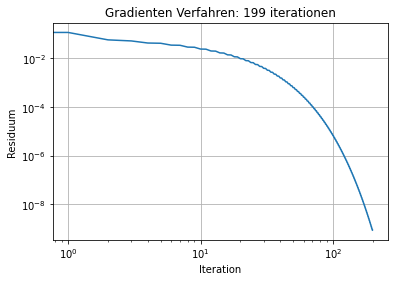

In [6]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Gradienten Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_GradientenVerfahren_fig", fig, display=False)

Es ist zu sehen, dass die Gradientenmethode ähnlich schnell wie die Richardson-Iteration konvergiert, jedoch ohne die Notwendigkeit eines gut gewählten Relaxationsparameters $\alpha$.

Der Vergleich mit der Richardson-Iteration erlaubt es auch, die Fehlerreduktion der Gradientenmethode abzuschätzen. Sei

$$
\tilde x^{k+1} = x^k - \alpha_\text{Rich} (b - A x^k)
$$

ein Schritt des Richardson Verfahren. Dann gilt

$$
\| x^{k+1} - x^\ast \|_A^2 = 2 \, (f(x^{k+1}) - f(x^\ast)) 
\leq 2 \, ( f (\tilde x^{k+1}) - f(x^\ast) ) = \| \tilde x^{k+1} - x^\ast \|_A^2
$$

Ein Schritt der Gradientenmethode reduziert den Fehler (gemessen in der Energienorm) mindestens so stark wie ein Schritt der Richardson-Methode.

In [7]:
gfu.vec[:] = sol
Draw(gfu,mesh,'u')

WebGuiWidget(value={'ngsolve_version': '6.2.2104-121-gee6902d12', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, '…

BaseWebGuiScene